# RAG Fusion

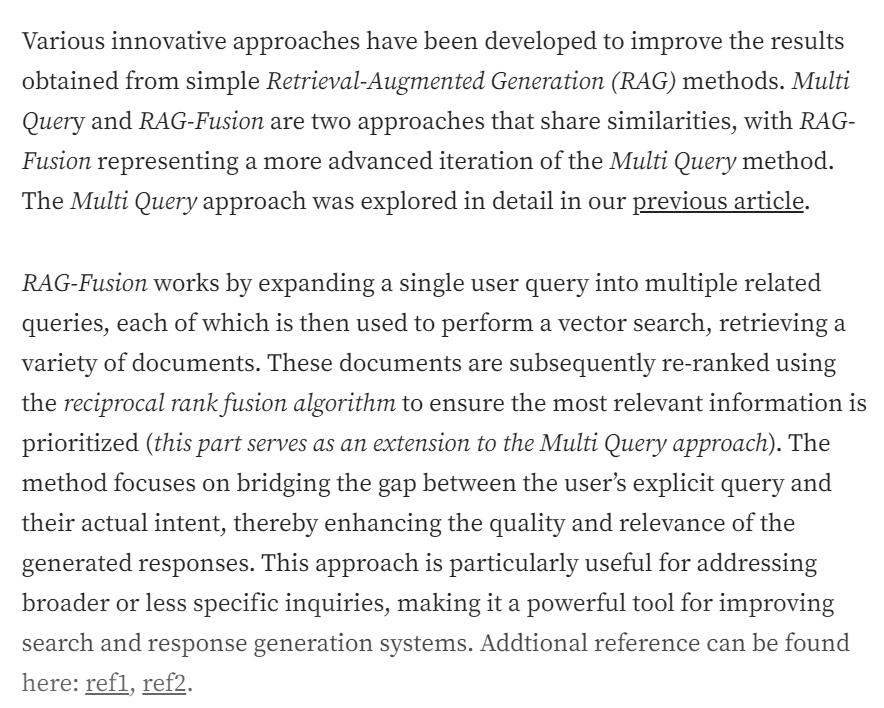

In [1]:
!pip -q install langchain huggingface_hub langchain-google-genai tiktoken pypdf
!pip -q install google-generativeai chromadb unstructured
!pip -q install sentence_transformers
!pip -q install -U FlagEmbedding


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

### Download the Data & Utils

In [2]:
import os
import requests
import zipfile
from io import BytesIO
import textwrap

def download_and_extract_zip(url, target_folder):
    # Ensure the target folder exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Download the file from the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Unzip the file in memory
    with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(target_folder)

    print(f"Files extracted to {target_folder}")


def zip_folder(folder_path, zip_file_path):
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Create a path relative to the folder to avoid storing absolute paths
                relative_path = os.path.relpath(os.path.join(root, file), os.path.dirname(folder_path))
                # Add file to the zip file
                zipf.write(os.path.join(root, file), arcname=relative_path)

    print(f"{zip_file_path} created successfully.")



def wrap_text(text, width=90): #preserve_newlines
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

# URL of the zip file
url = "https://www.dropbox.com/scl/fi/av3nw07o5mo29cjokyp41/singapore_text_files_languages.zip?rlkey=xqdy5f1modtbnrzzga9024jyw&dl=1" # Ensure dl=1 for direct download

# Folder to save extracted files
folder = "singapore_text"

# Call the function
download_and_extract_zip(url, folder)


Files extracted to singapore_text


In [3]:
## download the chroma DB
url = 'https://www.dropbox.com/scl/fi/3kep8mo77h642kvpum2p7/singapore_chroma_db.zip?rlkey=4ry4rtmeqdcixjzxobtmaajzo&dl=1'
download_and_extract_zip(url, '.')

Files extracted to .


In [4]:
import os

from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [5]:
!pip show langchain

Name: langchain
Version: 0.2.6
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


## Google

## Imports

In [7]:
!pip install -q langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.2 MB/s eta 0:00:00


In [8]:
from langchain.llms import GooglePalm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.chroma import Chroma
import langchain



## Load in Docs

In [9]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import TextLoader

In [10]:
%%time
loader = DirectoryLoader('/content/singapore_text/Textfiles3/English/', glob="*.txt", show_progress=True)
docs = loader.load()

  0%|          | 0/646 [00:00<?, ?it/s][nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
100%|██████████| 646/646 [00:38<00:00, 16.89it/s]

CPU times: user 34.7 s, sys: 1.22 s, total: 35.9 s
Wall time: 38.3 s


In [11]:
len(docs)
# docs = docs[:10]
len(docs)

646

In [12]:
docs[0]

Document(metadata={'source': '/content/singapore_text/Textfiles3/English/LASALLE_College_of_the_Arts.txt'}, page_content='Link: https://www.visitsingapore.com/see\n\ndo\n\nsingapore/architecture/modern/lasalle\n\ncollege\n\nof\n\nthe\n\narts/\n\nTitle: LASALLE College of the Arts\n\nIt seems fitting that an institution providing tertiary education in the arts should push the boundaries of creativity in architecture. That’s exactly what the LASALLE College of the Arts does.\n\nIngenious space\n\nDesigned by Singapore-based RSP Architects, the campus is an ingenious exercise of reworking space. From the outside, visitors are confronted by a black monolithic exterior of stone and aluminium punctuated with irregularly-shaped windows.\n\nThis illusion of continuity disappears when visitors enter the building, with its six seven-storey-high buildings, linked by an atrium and sky bridges. In contrast to its exterior, the buildings here are stunningly graphic, with faceted glass walls and indi

In [13]:
raw_text = ''
for i, doc in enumerate(docs):
    text = doc.page_content
    if text:
        raw_text += text

In [14]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap  = 100,
    length_function = len,
    is_separator_regex = False,
)

In [15]:
texts = text_splitter.split_text(raw_text)

In [16]:
len(texts)

6218

In [17]:
texts[1]

'Ingenious space\n\nDesigned by Singapore-based RSP Architects, the campus is an ingenious exercise of reworking space. From the outside, visitors are confronted by a black monolithic exterior of stone and aluminium punctuated with irregularly-shaped windows.'

## BGE Embeddings

In [18]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

embedding_function = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs=encode_kwargs,

)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Vector DB

In [19]:
%%time
### Make the chroma and persiste to disk
# db = Chroma.from_texts(texts,
#                        embedding_function,
#                        persist_directory="./chroma_db")



### load from disk
db = Chroma(persist_directory="./chroma_db", embedding_function=embedding_function)





CPU times: user 1.37 s, sys: 54.2 ms, total: 1.42 s
Wall time: 1.79 s


In [ ]:
### Save to zip
# zip_folder('/content/chroma_db', 'chroma_db.zip')

chroma_db.zip created successfully.


In [20]:
query = "Tell me about Universal Studios Singapore?"

db.similarity_search(query, k=5)

[Document(page_content='Universal Studios Singapore'),
 Document(page_content='Universal Studios Singapore is a popular theme park that offers thrilling rides and entertainment for all ages. You can buy Universal Studios Singapore tickets and enjoy an unbeatable discount of 40% from MySingaporePass. The pass provides a hassle-free booking process, allowing you to skip the long queues and gain easy access to the park. Enjoy exhilarating roller coasters, live shows, and immersive themed zones inspired by your favorite movies. The discounted entry with My Singapore Pass'),
 Document(page_content='leisure/fun\n\nthings\n\nto\n\ndo/universal\n\nstudios\n\nsingapore/\n\nTitle: Universal Studios Singapore\n\nThe shimmering wonders of the silver screen comes to vivid life at Universal Studios Singapore, the first-ever Hollywood movie theme park in Southeast Asia.'),
 Document(page_content='The magic of Hollywood comes to life at Universal Studios Singapore (USS), a theme park filled with adren

## Setup a Retriever

In [21]:
retriever = db.as_retriever(k=5) # can add mmr fetch_k=20, search_type="mmr"

retriever.get_relevant_documents(query)[1]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Document(page_content='Universal Studios Singapore is a popular theme park that offers thrilling rides and entertainment for all ages. You can buy Universal Studios Singapore tickets and enjoy an unbeatable discount of 40% from MySingaporePass. The pass provides a hassle-free booking process, allowing you to skip the long queues and gain easy access to the park. Enjoy exhilarating roller coasters, live shows, and immersive themed zones inspired by your favorite movies. The discounted entry with My Singapore Pass')

## Chat chain

In [22]:
from operator import itemgetter

from langchain.chat_models import ChatGooglePalm

from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough

In [23]:

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatGooglePalm()

In [24]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [25]:
text_reply = chain.invoke("Tell me about Universal Studio Singapore")

print(wrap_text(text_reply))

Universal Studios Singapore is a theme park located at Resorts World Sentosa on Sentosa
Island, Singapore. It is the first Universal Studios theme park in Southeast Asia. The
park opened on 18 September 2010, and is the second Universal Studios park to open in Asia
after Universal Studios Japan.

The park is divided into seven themed zones: Hollywood, New York, Sci-Fi City, Ancient
Egypt, The Lost World, Far Far Away, and Madagascar. Each zone is home to a variety of
rides, shows, and attractions based on popular movies and television shows.

Some of the most popular rides at Universal Studios Singapore include:

* The Mummy Ride: A roller coaster that takes guests on a journey through the tomb of
Imhotep.
* Transformers: The Ride-3D: A 3D motion simulator ride that puts guests in the middle of
a battle between the Autobots and the Decepticons.
* Jurassic Park Rapids Adventure: A water ride that takes guests on a journey through the
Jurassic Park lagoon.
* Shrek 4-D Adventure: A 4D mot

## With RagFusion

In [26]:
from langchain.chat_models import ChatGooglePalm
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.prompts import ChatMessagePromptTemplate, PromptTemplate

In [27]:
prompt = ChatPromptTemplate(input_variables=['original_query'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant that generates multiple search queries based on a single input query.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['original_query'], template='Generate multiple search queries related to: {question} \n OUTPUT (4 queries):'))])

In [28]:
# prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are a helpful assistant that generates multiple search queries based on a single input query."),
#     ("user", "Generate multiple search queries related to: {question}/n OUTPUT (4 queries):"),
# ])

prompt

ChatPromptTemplate(input_variables=['question'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant that generates multiple search queries based on a single input query.')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], template='Generate multiple search queries related to: {question} \n OUTPUT (4 queries):'))])

In [29]:
generate_queries = (
    prompt | ChatGooglePalm(temperature=0) | StrOutputParser() | (lambda x: x.split("\n"))
)

In [30]:
original_query = "universal studios Singapore"

In [31]:
from langchain.load import dumps, loads


def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    for docs in results:
        # Assumes the docs are returned in sorted order of relevance
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    return reranked_results

In [32]:
ragfusion_chain = generate_queries | retriever.map() | reciprocal_rank_fusion

In [33]:
langchain.debug = True

In [34]:
ragfusion_chain.input_schema.schema()

{'title': 'PromptInput',
 'type': 'object',
 'properties': {'question': {'title': 'Question', 'type': 'string'}}}

In [35]:
ragfusion_chain.invoke({"question": original_query})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "universal studios Singapore"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "universal studios Singapore"
}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatGooglePalm] Entering LLM run with input:
{
  "prompts": [
    "System: You are a helpful assistant that generates multiple search queries based on a single input query.\nHuman: Generate multiple search queries related to: universal studios Singapore \n OUTPUT (4 queries):"
  ]
}
[llm/end] [chain:RunnableSequence > llm:ChatGooglePalm] [4.33s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "Here are 4 search queries related to Universal Studios Singapore:\n\n1. What are the rides at Universal Studios Singapore?\n2. How much does it cost to go

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


[(Document(page_content='Universal Studios Singapore'), 0.06666666666666667),
 (Document(page_content='Universal Studios Singapore is a popular theme park that offers thrilling rides and entertainment for all ages. You can buy Universal Studios Singapore tickets and enjoy an unbeatable discount of 40% from MySingaporePass. The pass provides a hassle-free booking process, allowing you to skip the long queues and gain easy access to the park. Enjoy exhilarating roller coasters, live shows, and immersive themed zones inspired by your favorite movies. The discounted entry with My Singapore Pass'),
  0.06558258417063283),
 (Document(page_content='Here are some of the top attractions that can be booked with the My Singapore Pass:\n\nUniversal Studios Singapore @ 40% Off'),
  0.048651507139079855),
 (Document(page_content='leisure/fun\n\nthings\n\nto\n\ndo/universal\n\nstudios\n\nsingapore/\n\nTitle: Universal Studios Singapore\n\nThe shimmering wonders of the silver screen comes to vivid lif

In [36]:
from langchain.schema.runnable import RunnablePassthrough
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

full_rag_fusion_chain = (
    {
        "context": ragfusion_chain,
        "question": RunnablePassthrough()
    }
    | prompt
    | model
    | StrOutputParser()
)

In [37]:
full_rag_fusion_chain.input_schema.schema()

{'title': 'RunnableParallel<context,question>Input',
 'type': 'object',
 'properties': {'question': {'title': 'Question', 'type': 'string'}}}

In [38]:
full_rag_fusion_chain.invoke({"question": "Tell me about Universal Studio Singapore?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "Tell me about Universal Studio Singapore?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain

'Universal Studios Singapore is a theme park located on Sentosa Island in Singapore. It is the first Universal Studios theme park in Southeast Asia. The park opened on 18 September 2010.\n\nUniversal Studios Singapore is divided into seven themed zones:\n\n* Hollywood: This zone is home to rides and attractions based on Hollywood movies, such as Transformers The Ride: The Ultimate 3D Battle and The Mummy: The Ride.\n* New York: This zone is home to rides and attractions based on New York City, such as Revenge of the Mummy and Battlestar Galactica: HUMAN vs. CYLON.\n* Sci-Fi City: This zone is home to rides and attractions based on science fiction movies, such as Battlestar Galactica: HUMAN vs. CYLON and TRANSFORMERS The Ride: The Ultimate 3D Battle.\n* Ancient Egypt: This zone is home to rides and attractions based on ancient Egypt, such as Revenge of the Mummy and The Mummy: The Ride.\n* Far Far Away: This zone is home to rides and attractions based on the Shrek movies, such as Shrek 